# LAB 8 - P1: Dog GAN
### Hecho por: Joshua Sancho y Steven Solís

## Importar Librerías

In [2]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
from zipfile import ZipFile
import imageio
from PIL import Image
from IPython.display import HTML
from tqdm import tqdm
import time
from Diff_Augment import DiffAugment

## Exploración de los Datos

Found 22119 files belonging to 1 classes.


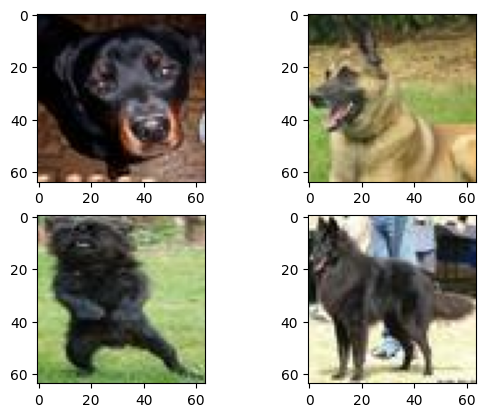

In [5]:
tf.keras.utils.set_random_seed(14)
batch_size = 32
dataset = preprocessing.image_dataset_from_directory(
    "dog_dataset", label_mode=None, image_size=(64, 64), batch_size=batch_size
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

trained_models_folder = "models/"
generated_images_folder = "output/"

for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(((batch.numpy() + 1) / 2)[i])
    break
plt.show()

## Modelo Discriminador

In [3]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                               use_bias=False),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                               use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                               use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                               use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name="discriminator")
    return model


## Modelo Generador

In [4]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(4 * 4 * 512),
        tf.keras.layers.Reshape((4, 4, 512)),
        tf.keras.layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                        use_bias=False, activation='tanh')
    ], name="generator")
    return model

In [5]:
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

generator.summary()
discriminator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3276800   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      81

## Test de Salida

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


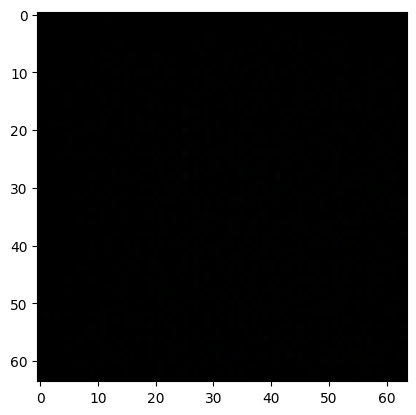

In [6]:
random_noise = tf.random.normal([1, latent_dim])
generated_image = generator(random_noise, training=False)
plt.imshow(generated_image[0])
plt.show()

## Entrenamiento de DCGAN

In [7]:
decision = discriminator(generated_image)
print('decision', decision)
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

decision tf.Tensor([[0.49997663]], shape=(1, 1), dtype=float32)


In [8]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    images = DiffAugment(images, policy='color,translation,cutout')

    with tf.GradientTape() as disc_tape1:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images,policy='color,translation,cutout')

        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)

    gradients_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_disc1, discriminator.trainable_variables))

    with tf.GradientTape() as disc_tape2:
        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)

    gradients_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_disc2, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return disc_loss1 + disc_loss2, gen_loss

In [9]:
seed = tf.random.normal([25, latent_dim])
disc_losses = []
gen_losses = []
def train(dataset, epochs):
    generate_and_save_images(generator, 0, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_0")
    generator.save(trained_models_folder + "Generator_epoch_0")
    for epoch in range(epochs):
        disc_loss = gen_loss = 0
        print('Currently training on epoch {} (out of {}).'.format(epoch+1, epochs))
        for image_batch in tqdm(dataset):
            losses = train_step(image_batch)
            disc_loss += losses[0]
            gen_loss += losses[1]

        generate_and_save_images(generator, epoch+1, seed)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        if epoch % 100 == 0:
            discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epoch)
            generator.save(trained_models_folder + "Generator_epoch_%d" % epoch)

    generate_and_save_images(generator, epochs, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epochs)
    generator.save(trained_models_folder + "Generator_epoch_%d" % epochs)

In [10]:
def generate_and_save_images(model, epoch, seed, dim =(5, 5), figsize=(5, 5)):
    generated_images = model(seed)
    generated_images *= 255
    generated_images.numpy()
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig(generated_images_folder + 'generated_image_epoch_%d.png' % epoch)
    plt.close()

In [ ]:
train(dataset, 500)

## Outputs por Epoch

In [7]:
def generate_video_from_images(folder_path, output_video, fps):

    image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    image_files.sort()
    
    with open('images.txt', 'w') as file:
        for image_file in image_files:
            img_path = os.path.join(folder_path, image_file)
            file.write(f"file '{img_path}'\n")
    
    ffmpeg_command = [
        'ffmpeg',
        '-y',  
        '-r', str(fps),
        '-f', 'concat',
        '-safe', '0',
        '-i', 'images.txt',
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        output_video
    ]
    
    subprocess.run(ffmpeg_command)
    
    os.remove('images.txt')
    
    print(f"Video created successfully: {output_video}")

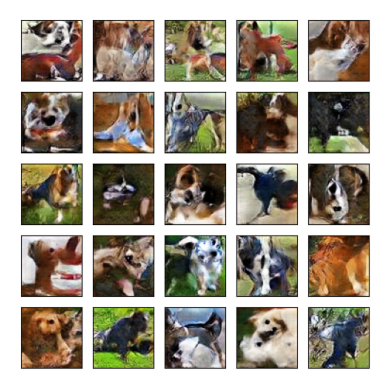

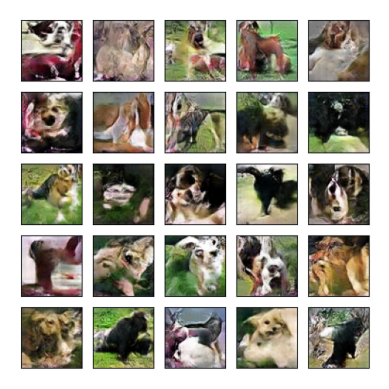

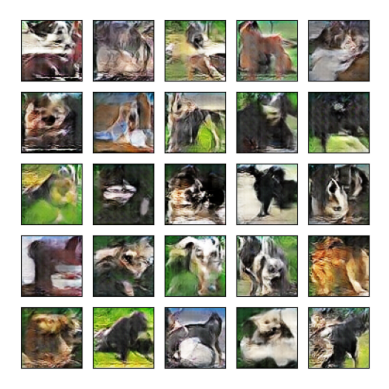

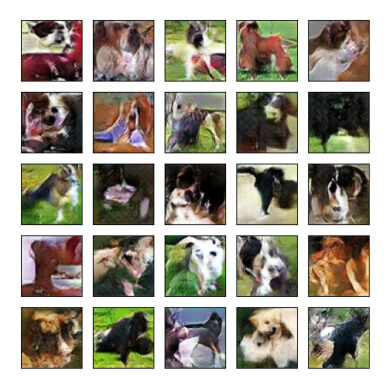

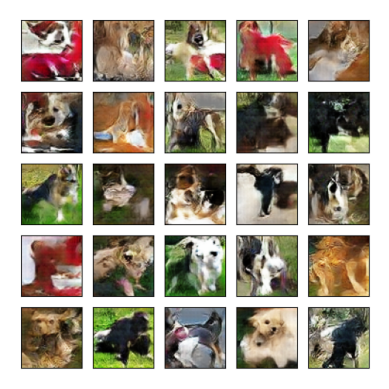

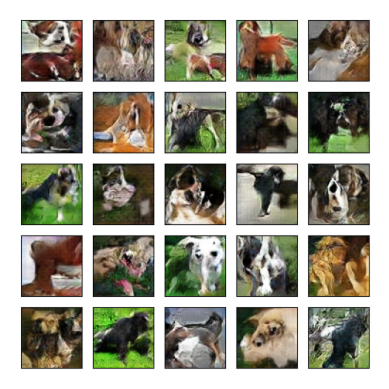

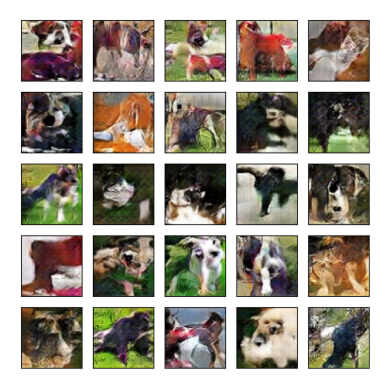

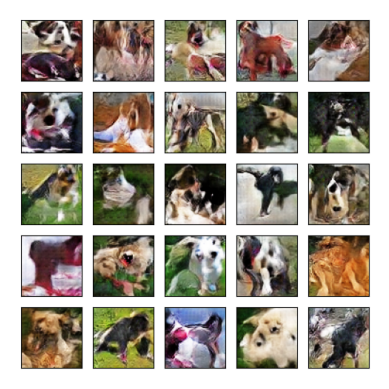

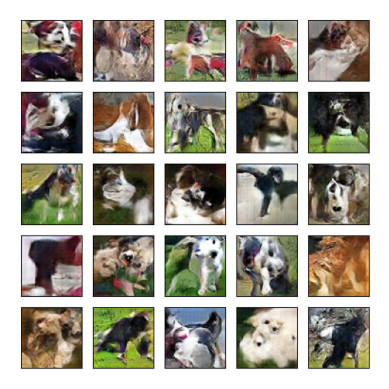

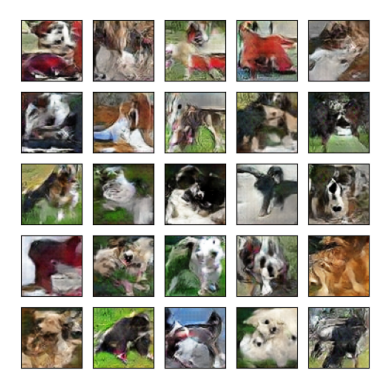

Video created successfully: dog_gan_output.mp4


In [8]:
output_video = 'dog_gan_output.mp4'
fps = 30

image_files = [f for f in os.listdir(generated_images_folder) if f.endswith('png')]
image_files.sort()

images = []
for image_file in image_files:
    img_path = os.path.join(generated_images_folder, image_file)
    img = Image.open(img_path)
    images.append(img)

for img in images[-10:]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()
  
generate_video_from_images(generated_images_folder, output_video, fps) 

## Conclusión
Luego de 500 epochs la GAN fue capaz de generar imágenes relativamente similares a las de un perro, sin embargo, aún no es capaz de conseguir crear imágenes realmente convincentes.